In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchmetrics.functional import auc

import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm

import warnings
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve
warnings.simplefilter('ignore')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla P100-PCIE-16GB


In [13]:
BATCH_SIZE=8
EPOCH=35
LEARNING_RATE=0.001

data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../input/augmented-alzheimer-mri-dataset-v2/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                    for x in ['train', 'val']}
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0)
                                            }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(40,40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

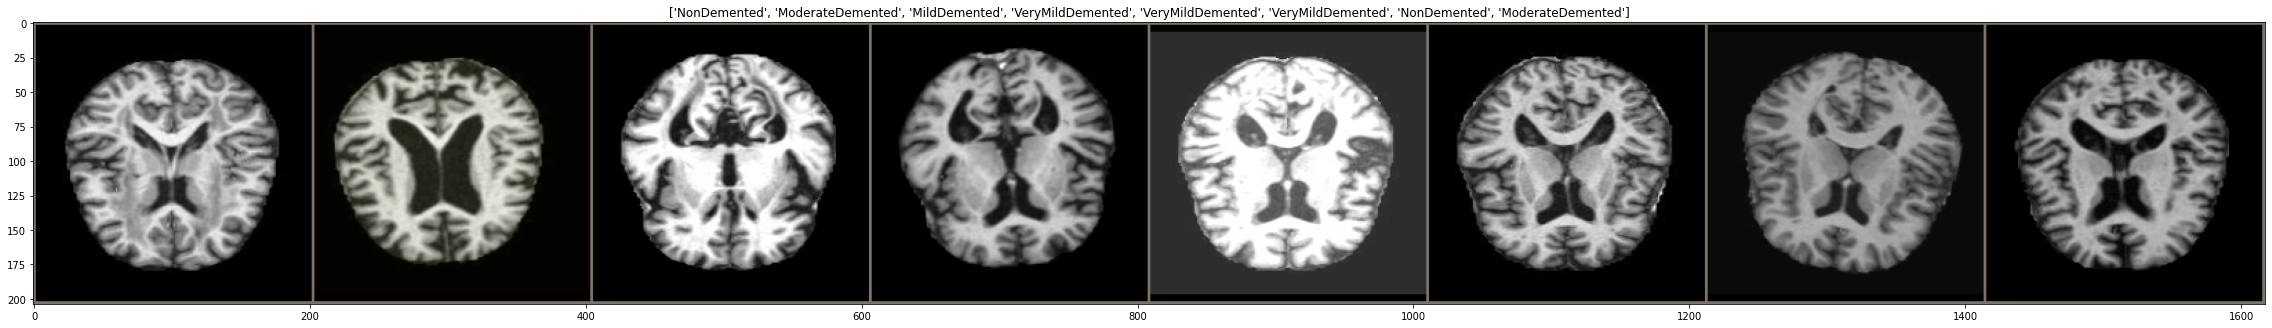

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [20]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):

    #Creating a folder to save the model performance.
    try:
        os.mkdir(f'modelPerformance/{name}')
    except:
        print('Dosya var')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(image_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            
            #epoch_auc= running_auc/(dataset_sizes[phase]-error)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                #torch.save(model,'modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))
                torch.save(model.state_dict(), 'modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))
                train_losses = []
                valid_losses = []

                
            
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'modelPerformance/{name}/'+sorted(os.listdir(f'modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [21]:
resnext50 =models.resnext50_32x4d(pretrained=True)
num_ftrs = resnext50.fc.in_features
resnext50.fc =  nn.Linear(num_ftrs, len(class_names))
resnext50=resnext50.to(device)
resnext50.fc.fc_out=nn.Linear(80,80)


resnet50 =models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc =  nn.Linear(num_ftrs, len(class_names))
resnet50=resnet50.to(device)
resnet50.fc.fc_out=nn.Linear(80,80)


vgg16 =models.vgg16(pretrained=True)
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 512)])
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

for param in vgg16.features.parameters():
    param.require_grad = False
for param in resnext50.parameters():
    param.require_grad = False
for param in resnet50.parameters():
    param.require_grad = False


class Ensemble(nn.Module):
    def __init__(self):
        super(Ensemble, self).__init__()

        self.modelA = resnext50
        self.modelB = resnet50
        self.modelC = vgg16

        self.hidden = nn.Linear(520, 520)
        self.classifier = nn.Linear(520, 4)

    def forward(self, x):

        x1 = self.modelA(x.clone())
        x1 = x1.view(x1.size(0), -1)

        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)

        x3 = self.modelC(x)
        x3 = x3.view(x3.size(0), -1)

        x = torch.cat((x1, x2, x3), dim=1)#
        x = self.hidden(torch.softmax(x, dim=1)) 
        x = self.classifier(torch.softmax(x, dim=1))

        return x 
modeller={
    'ensemble':Ensemble()
}


try:
    os.mkdir('./modelPerformance')
except:
    print('modelPerformance Exists')

modelPerformance Exists


In [ ]:
for name,model in modeller.items(): 
    model_ft = model

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.0001)


    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

Dosya var
Epoch 1/35
----------


  3%|▎         | 108/4248 [00:27<16:52,  4.09it/s]